In [1]:
import numpy as np
import os
import random
import pickle
import pandas as pd
from scipy.special import softmax
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

/vision/asomaya1/anaconda3/envs/sounding_narrations/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output_dir = "/vision/asomaya1/epic-sounds-annotations/src/outputs"
video_id = "P01_01" #options: {val, test} NOTE: test cannot be analyzed as we don't have GT - it is for the EPIC-KITCHENS challenge.
output_file = f"scores/EPIC_Sounds_recognition_{video_id}_test_timestamps.pkl"

In [3]:
with open(os.path.join(output_dir, video_id, output_file), 'rb') as f:
    pred_annotations = pickle.load(f)
    
probabilities = softmax(pred_annotations['interaction_output'], axis=1)
pred_labels = np.argsort(-probabilities, axis=1)[:, :1]

In [8]:
import numpy as np

# Define a threshold for similarity
similarity_threshold = 0.9

# Initialize the boundaries list
boundaries = []

# Iterate over the probabilities
for i in range(1, probabilities.shape[0]):
    # Calculate the similarity between the current and previous class distributions
    similarity = np.dot(probabilities[i], probabilities[i-1]) / (np.linalg.norm(probabilities[i]) * np.linalg.norm(probabilities[i-1]))
    
    # If the similarity is below the threshold, add the current index as a boundary
    if similarity < similarity_threshold:
        boundaries.append(i)

# Add the first and last indices as boundaries
boundaries = [0] + boundaries + [probabilities.shape[0]-1]

# Print the boundaries
print(boundaries)

[0, 1, 3, 5, 6, 7, 8, 10, 13, 14, 15, 19, 22, 23, 24, 25, 27, 28, 29, 32, 33, 37, 39, 40, 42, 43, 44, 45, 47, 49, 50, 52, 54, 55, 57, 58, 59, 60, 61, 68, 72, 83, 85, 87, 90, 91, 93, 94, 95, 96, 99, 100, 101, 102, 103, 104, 105, 107, 109, 111, 112, 114, 115, 122, 124, 126, 127, 128, 141, 142, 144, 145, 146, 148, 149, 153, 154, 155, 156, 158, 160, 163, 165, 166, 167, 169, 170, 171, 172, 173, 178, 179, 180, 183, 184, 186, 188, 193, 194, 195, 196, 198, 199, 201, 202, 204, 205, 213, 214, 216, 217, 219, 221, 222, 224, 225, 226, 229, 230, 233, 234, 235, 237, 238, 239, 240, 241, 248, 253, 254, 255, 256, 258, 260, 261, 262, 263, 267, 268, 269, 270, 272, 273, 275, 276, 277, 278, 279, 280, 281, 282, 284, 285, 286, 287, 288, 289, 291, 293, 294, 295, 300, 301, 302, 303, 316, 319, 321, 322, 326, 327, 328, 329, 330, 331, 333, 337, 339, 341, 343, 345, 347, 348, 349, 351, 352, 363, 364, 368, 371, 372, 377, 378, 380, 382, 383, 385, 386, 387, 389, 390, 392, 396, 397, 399, 400, 401, 403, 404, 405, 407, 40

In [7]:
# Load audio file
audio_path = '/vision/vision_data/EPIC-KITCHENS/EPIC-KITCHENS/asf_audio/P01_01.wav'
audio, sr = librosa.load(audio_path, sr=None)

# Trim the audio to the first three minutes (180 seconds)
N = 1620
N_seconds_samples = N * sr
audio = audio[:N_seconds_samples]
audio_assignment_scheme = "random" #options: 'best', 'random'

# Load class predictions
predictions =pred_labels.flatten()[:int(N / 0.5)]  # Load and trim

# Load class mapping
with open('/vision/asomaya1/epic-sounds-annotations/annotation_mapping.pkl', 'rb') as file:
    class_mapping = pickle.load(file)

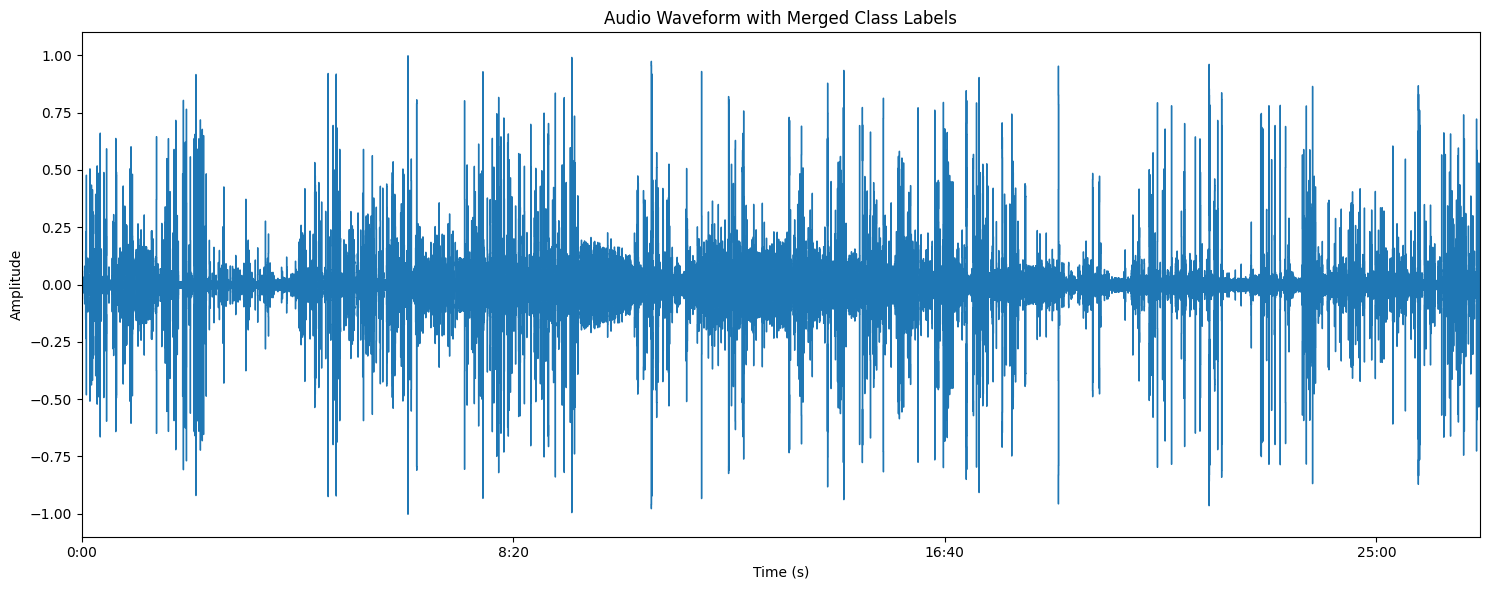

In [5]:
# Identify contiguous segments and calculate their intervals
unique_predictions = []
start_times = []
end_times = []

current_pred = predictions[0]
start_time = 0

for i, pred in enumerate(predictions[1:], start=1):
    if pred != current_pred:
        unique_predictions.append(current_pred)
        start_times.append(start_time * 0.5)
        end_times.append((i - 1) * 0.5 + 3)  # Adding window duration to last index
        current_pred = pred
        start_time = i

# Adding the last segment
unique_predictions.append(current_pred)
start_times.append(start_time * 0.5)
end_times.append((len(predictions) - 1) * 0.5 + 3)

# Plotting
plt.figure(figsize=(15, 6))
librosa.display.waveshow(audio, sr=sr)
plt.title('Audio Waveform with Merged Class Labels')

""" # Annotate merged class predictions
for pred, start, end in zip(unique_predictions, start_times, end_times):
    mid_point = (start + end) / 2
    plt.annotate(class_mapping[pred][0],
                 (mid_point, 0),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center',
                 rotation=90)
    plt.axvline(x=start, color='red', linestyle='--')  # Start of the segment
    plt.axvline(x=end, color='green', linestyle='--')  # End of the segment """

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim([0, N])  # Limiting x-axis to three minutes
plt.tight_layout()
plt.show()

In [6]:
narrations_df = pd.read_csv('/vision/vision_data/EPIC-KITCHENS/epic-kitchens-100-annotations/EPIC_100_train.csv')
narrations_df = narrations_df[(narrations_df['participant_id'] == 'P01') & (narrations_df['video_id'] == 'P01_01')]
narrations = narrations_df[['start_timestamp', 'stop_timestamp', 'narration']].copy()
narrations['start_seconds'] = pd.to_datetime(narrations['start_timestamp'], format='%H:%M:%S.%f').dt.time
narrations['stop_seconds'] = pd.to_datetime(narrations['stop_timestamp'], format='%H:%M:%S.%f').dt.time
narrations['start_seconds'] = narrations['start_seconds'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second + x.microsecond / 1e6)
narrations['stop_seconds'] = narrations['stop_seconds'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second + x.microsecond / 1e6)

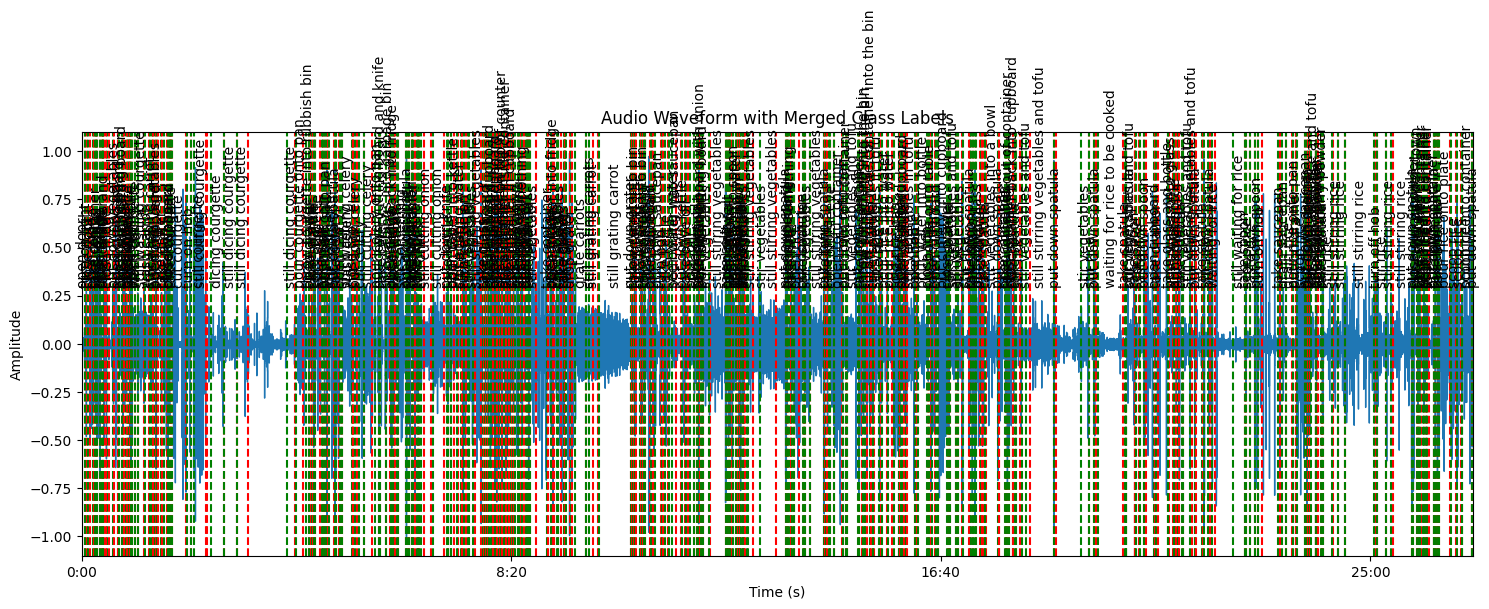

In [7]:
# Setup
output_dir = "/vision/asomaya1/epic-sounds-annotations/src/outputs"
video_id = "P01_01"
output_file = f"scores/EPIC_Sounds_recognition_{video_id}_test_timestamps.pkl"

# Load predictions
with open(os.path.join(output_dir, video_id, output_file), 'rb') as f:
    pred_annotations = pickle.load(f)
    
# Calculate probabilities and predict labels
probabilities = softmax(pred_annotations['interaction_output'], axis=1)
pred_labels = np.argsort(-probabilities, axis=1)[:, :1]

# Load audio file
audio_path = '/vision/vision_data/EPIC-KITCHENS/EPIC-KITCHENS/asf_audio/P01_01.wav'
audio, sr = librosa.load(audio_path, sr=None)
audio = audio[:N * sr]

# Load class mapping
with open('/vision/asomaya1/epic-sounds-annotations/annotation_mapping.pkl', 'rb') as file:
    class_mapping = pickle.load(file)

# Setup figure for plotting
plt.figure(figsize=(15, 6))
librosa.display.waveshow(audio, sr=sr)
plt.title('Audio Waveform with Merged Class Labels')

# Load narrations
narrations_df = pd.read_csv('/vision/vision_data/EPIC-KITCHENS/epic-kitchens-100-annotations/EPIC_100_train.csv')
narrations_df = narrations_df[(narrations_df['participant_id'] == 'P01') & (narrations_df['video_id'] == 'P01_01')]
narrations = narrations_df[['start_timestamp', 'stop_timestamp', 'narration']].copy()

# Reference datetime for calculating total seconds
reference_time = pd.to_datetime('00:00:00.000', format='%H:%M:%S.%f')

# Convert timestamps to seconds
narrations['start_seconds'] = (pd.to_datetime(narrations['start_timestamp'], format='%H:%M:%S.%f') - reference_time).dt.total_seconds()
narrations['stop_seconds'] = (pd.to_datetime(narrations['stop_timestamp'], format='%H:%M:%S.%f') - reference_time).dt.total_seconds()
for _, row in narrations.iterrows():
    mid_point = (row['start_seconds'] + row['stop_seconds']) / 2
    plt.annotate(row['narration'],
                 (mid_point, 0),
                 textcoords="offset points",
                 xytext=(0, 40),  # Position text below the waveform
                 ha='center',
                 va='bottom',
                 rotation=90)  # Vertical text for clarity
    plt.axvline(x=row['start_seconds'], color='green', linestyle='--')  # Start of the segment
    plt.axvline(x=row['stop_seconds'], color='red', linestyle='--')  # End of the segment

# Finalize plot
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim([0, N])  # Limiting x-axis to N seconds
plt.tight_layout()
plt.show()

### Format DataFrames for analysis:

In [8]:
narrations = narrations.sort_values('start_seconds')
narrations_df = narrations[narrations.stop_seconds <=N].reset_index(drop=True)
audio_events = [class_mapping[pred][0] for pred in unique_predictions]
audio_events_df = pd.DataFrame({"description": audio_events, "start_seconds": start_times, "stop_seconds": end_times})
audio_events_df = audio_events_df[audio_events_df.stop_seconds <=N]

In [9]:
# Load your dataframes and initialize SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

# Embedding text
narration_embeddings = model.encode(narrations_df['narration'].tolist(), convert_to_tensor=True).cpu()
audio_event_embeddings = model.encode(audio_events_df['description'].tolist(), convert_to_tensor=True).cpu()

# Find the closest narrations based on time intervals
def find_closest_narrations(audio_event_row):
    before_narrations = narrations_df[narrations_df['stop_seconds'] <= audio_event_row['start_seconds']]
    after_narrations = narrations_df[narrations_df['start_seconds'] >= audio_event_row['stop_seconds']]

    closest_before = before_narrations.iloc[-1] if not before_narrations.empty else None
    closest_after = after_narrations.iloc[0] if not after_narrations.empty else None
    return closest_before, closest_after

# Assigning audio events
def assign_audio_events(mode='best'):
    assignment = {}
    for audio_idx, audio_event_row in audio_events_df.iterrows():
        overlaps = []
        for nar_idx, nar_row in narrations_df.iterrows():
            if nar_row['start_seconds'] <= audio_event_row['stop_seconds'] and nar_row['stop_seconds'] >= audio_event_row['start_seconds']:
                similarity = cosine_similarity(narration_embeddings[nar_idx].reshape(1, -1), audio_event_embeddings[audio_idx].reshape(1, -1))[0][0]
                overlaps.append((nar_idx, similarity))

        if overlaps:
            if mode=='best':
                best_narration = max(overlaps, key=lambda x: x[1])
            elif mode=='random':
                best_narration = random.choice(overlaps)
            assignment[audio_idx] = best_narration
        else:
            closest_before, closest_after = find_closest_narrations(audio_event_row)
            closest_narrations = []
            if closest_before is not None:
                sim_before = cosine_similarity(narration_embeddings[closest_before.name].reshape(1, -1), 
                                               audio_event_embeddings[audio_idx].reshape(1, -1))[0][0]
                closest_narrations.append((closest_before.name, sim_before))
            if closest_after is not None:
                sim_after = cosine_similarity(narration_embeddings[closest_after.name].reshape(1, -1), 
                                              audio_event_embeddings[audio_idx].reshape(1, -1))[0][0]
                closest_narrations.append((closest_after.name, sim_after))

            # If no narrations before or after, choose the closest available
            if not closest_narrations:
                if closest_before:
                    assignment[audio_idx] = (closest_before.name, sim_before)
                elif closest_after:
                    assignment[audio_idx] = (closest_after.name, sim_after)
            else:
                if mode=='best':
                    best_narration = max(closest_narrations, key=lambda x: x[1])
                elif mode=='random':
                    best_narration = random.choice(closest_narrations)
                #best_narration = max(closest_narrations, key=lambda x: x[1])
                assignment[audio_idx] = best_narration

    return assignment

audio_event_to_narration = assign_audio_events(mode=audio_assignment_scheme)

# Calculating and storing the union of assigned audio event intervals
narration_segments = {idx: [] for idx in narrations_df.index}
for ae_idx, (nar_idx, _) in audio_event_to_narration.items():
    narration_segments[nar_idx].append((audio_events_df.loc[ae_idx, 'start_seconds'], audio_events_df.loc[ae_idx, 'stop_seconds']))

for idx in narration_segments:
    sorted_intervals = sorted(narration_segments[idx], key=lambda x: x[0])
    merged_intervals = []
    for interval in sorted_intervals:
        if not merged_intervals or merged_intervals[-1][1] < interval[0]:
            merged_intervals.append(list(interval))
        else:
            merged_intervals[-1][1] = max(merged_intervals[-1][1], interval[1])
    narration_segments[idx] = merged_intervals

narrations_df['assigned_intervals'] = narrations_df.index.map(lambda x: narration_segments[x] if x in narration_segments else [])

/vision/asomaya1/anaconda3/envs/sounding_narrations/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/vision/asomaya1/anaconda3/envs/sounding_narrations/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
""" # Load dataframes and initialize SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

# Embedding text
narration_embeddings = model.encode(narrations_df['narration'].tolist(), convert_to_tensor=True).cpu()
audio_event_embeddings = model.encode(audio_events_df['description'].tolist(), convert_to_tensor=True).cpu()

# Function to assign audio events to narrations
def assign_audio_events():
    assignments = {idx: [] for idx in narrations_df.index}  # Dict to store assigned audio events and scores for each narration
    for audio_idx, audio_event_row in audio_events_df.iterrows():
        overlaps = []
        for nar_idx, nar_row in narrations_df.iterrows():
            if nar_row['start_seconds'] <= audio_event_row['stop_seconds'] and nar_row['stop_seconds'] >= audio_event_row['start_seconds']:
                similarity = cosine_similarity(narration_embeddings[nar_idx].reshape(1, -1), audio_event_embeddings[audio_idx].reshape(1, -1))[0][0]
                overlaps.append((nar_idx, similarity))

        # If overlaps exist, assign to the highest similarity narration
        if overlaps:
            best_narration = max(overlaps, key=lambda x: x[1])
            assignments[best_narration[0]].append((audio_event_row.description, best_narration[1]))
        else:
            closest_before, closest_after = find_closest_narrations(audio_event_row)
            closest_narrations = []
            if closest_before is not None:
                sim_before = cosine_similarity(narration_embeddings[closest_before.name].reshape(1, -1), audio_event_embeddings[audio_idx].reshape(1, -1))[0][0]
                closest_narrations.append((closest_before.name, sim_before))
            if closest_after is not None:
                sim_after = cosine_similarity(narration_embeddings[closest_after.name].reshape(1, -1), audio_event_embeddings[audio_idx].reshape(1, -1))[0][0]
                closest_narrations.append((closest_after.name, sim_after))

            # Choose the closest in terms of similarity
            if closest_narrations:
                best_narration = max(closest_narrations, key=lambda x: x[1])
                assignments[best_narration[0]].append((audio_event_row.description, best_narration[1]))

    return assignments

# Assign audio events
audio_event_assignments = assign_audio_events()

# Store assigned audio events and their cosine similarity scores in narrations_df
narrations_df['assigned_audio_events'] = narrations_df.index.map(lambda idx: [(f[0],f[1]) for f in audio_event_assignments[idx]] if idx in audio_event_assignments else []) """

" # Load dataframes and initialize SentenceTransformer\nmodel = SentenceTransformer('all-MiniLM-L6-v2')\n\n# Embedding text\nnarration_embeddings = model.encode(narrations_df['narration'].tolist(), convert_to_tensor=True).cpu()\naudio_event_embeddings = model.encode(audio_events_df['description'].tolist(), convert_to_tensor=True).cpu()\n\n# Function to assign audio events to narrations\ndef assign_audio_events():\n    assignments = {idx: [] for idx in narrations_df.index}  # Dict to store assigned audio events and scores for each narration\n    for audio_idx, audio_event_row in audio_events_df.iterrows():\n        overlaps = []\n        for nar_idx, nar_row in narrations_df.iterrows():\n            if nar_row['start_seconds'] <= audio_event_row['stop_seconds'] and nar_row['stop_seconds'] >= audio_event_row['start_seconds']:\n                similarity = cosine_similarity(narration_embeddings[nar_idx].reshape(1, -1), audio_event_embeddings[audio_idx].reshape(1, -1))[0][0]\n             

In [11]:
def merge_intervals(intervals):
    """ Merge overlapping intervals into a single list of intervals """
    if not intervals:
        return []

    # Sort intervals based on start time
    intervals.sort(key=lambda x: x[0])
    merged = [intervals[0]]

    for current_start, current_end in intervals[1:]:
        last_start, last_end = merged[-1]

        # If current interval overlaps with the last one, merge them
        if current_start <= last_end:
            merged[-1] = (last_start, max(last_end, current_end))
        else:
            merged.append((current_start, current_end))

    return merged

def interval_intersection(A, B):
    """ Find the intersection of two interval lists """
    i, j, intersection = 0, 0, []
    while i < len(A) and j < len(B):
        a_start, a_end = A[i]
        b_start, b_end = B[j]
        # Find the intersection range
        start = max(a_start, b_start)
        end = min(a_end, b_end)
        
        if start <= end:  # There is an overlap
            intersection.append((start, end))
        
        # Move to next interval in A or B
        if a_end < b_end:
            i += 1
        else:
            j += 1

    return intersection

def compute_iou(row):
    """ Compute the IoU based on ground truth and assigned intervals """
    ground_truth_intervals = [(row['start_seconds'], row['stop_seconds'])]
    assigned_intervals = row['assigned_intervals']

    if not assigned_intervals:
        return 0  # No IoU if there are no assigned intervals

    # Merge intervals to find the union
    union_intervals = merge_intervals(ground_truth_intervals + assigned_intervals)
    intersection_intervals = interval_intersection(ground_truth_intervals, assigned_intervals)

    # Calculate areas
    intersection_area = sum(end - start for start, end in intersection_intervals)
    union_area = sum(end - start for start, end in union_intervals)

    if union_area == 0:
        return 0  # Avoid division by zero

    return intersection_area / union_area

# Apply IoU computation to the dataframe
narrations_df['IoU'] = narrations_df.apply(compute_iou, axis=1)

In [12]:
# Filter out rows where 'assigned_intervals' is not empty
filtered_narrations = narrations_df[narrations_df['assigned_intervals'].apply(bool)]
# Compute the mean IoU for these filtered narrations
mean_iou = filtered_narrations['IoU'].mean()

In [13]:
# Assume total_duration is the total duration of the video
total_duration = N

# Number of narrations
num_narrations = len(narrations_df)

# Compute segment length
segment_length = total_duration / num_narrations

# Assign segments to narrations
narrations_df['baseline_start'] = np.arange(0, total_duration, segment_length)
narrations_df['baseline_stop'] = narrations_df['baseline_start'] + segment_length

# Function to calculate IoU for the baseline
def compute_baseline_iou(row):
    # Ground truth interval
    gt_start, gt_stop = row['start_seconds'], row['stop_seconds']
    # Baseline interval
    bl_start, bl_stop = row['baseline_start'], row['baseline_stop']
    
    intersection_start = max(gt_start, bl_start)
    intersection_stop = min(gt_stop, bl_stop)
    
    intersection = max(0, intersection_stop - intersection_start)
    union = (gt_stop - gt_start) + (bl_stop - bl_start) - intersection
    
    return intersection / union if union > 0 else 0

# Apply IoU calculation to the dataframe for baseline
narrations_df['baseline_IoU'] = narrations_df.apply(compute_baseline_iou, axis=1)

# Compute the mean baseline IoU
mean_baseline_iou = narrations_df['baseline_IoU'].mean()

def calculate_baseline_precision_recall(row):
    baseline_interval = (row['baseline_start'], row['baseline_stop'])
    ground_truth_interval = (row['start_seconds'], row['stop_seconds'])

    # Calculate intersection
    intersection_start = max(baseline_interval[0], ground_truth_interval[0])
    intersection_stop = min(baseline_interval[1], ground_truth_interval[1])
    intersection = max(0, intersection_stop - intersection_start)

    # Calculate union
    union_start = min(baseline_interval[0], ground_truth_interval[0])
    union_stop = max(baseline_interval[1], ground_truth_interval[1])
    union = union_stop - union_start

    precision = intersection / (baseline_interval[1] - baseline_interval[0]) if baseline_interval[1] - baseline_interval[0] > 0 else 0
    recall = intersection / (ground_truth_interval[1] - ground_truth_interval[0]) if ground_truth_interval[1] - ground_truth_interval[0] > 0 else 0

    return precision, recall

# Apply the function and store results
narrations_df[['baseline_precision', 'baseline_recall']] = narrations_df.apply(calculate_baseline_precision_recall, axis=1, result_type='expand')

# Calculate mean precision and recall for the baseline
mean_baseline_precision = narrations_df['baseline_precision'].mean()
mean_baseline_recall = narrations_df['baseline_recall'].mean()

### IoU Metrics:

In [14]:
def calculate_precision_recall(row):
    assigned_intervals = row['assigned_intervals']
    ground_truth = (row['start_seconds'], row['stop_seconds'])

    # Calculate intersection and union for precision and recall
    assigned_union = sum((min(ground_truth[1], ai[1]) - max(ground_truth[0], ai[0])) 
                         for ai in assigned_intervals 
                         if max(ground_truth[0], ai[0]) < min(ground_truth[1], ai[1]))

    total_assigned = sum((ai[1] - ai[0]) for ai in assigned_intervals)
    ground_truth_duration = ground_truth[1] - ground_truth[0]

    precision = assigned_union / total_assigned if total_assigned > 0 else 0
    recall = assigned_union / ground_truth_duration if ground_truth_duration > 0 else 0

    return precision, recall

# Apply the function and store results
narrations_df[['precision', 'recall']] = narrations_df.apply(calculate_precision_recall, axis=1, result_type='expand')

# Calculate mean precision and recall
mean_precision = narrations_df['precision'].mean()
mean_recall = narrations_df['recall'].mean()

In [15]:
# Assuming 'narrations_df' already includes necessary metrics calculations

# Define IoU thresholds
iou_thresholds = [0.1, 0.5, 0.7]

# Filter narrations that have at least one audio event assigned
filtered_narrations = narrations_df[narrations_df['assigned_intervals'].apply(bool)]

# Metrics for unfiltered audio-assignment
audio_assignment_metrics = {
    'Mean IoU': narrations_df['IoU'].mean(),
    #'Mean Precision': narrations_df['precision'].mean(),
    #'Mean Recall': narrations_df['recall'].mean(),
    **{f'IoU >= {threshold}': (narrations_df[narrations_df['IoU'] >= threshold].shape[0] / narrations_df.shape[0] * 100) for threshold in iou_thresholds}
}

# Metrics for filtered audio-assignment
audio_assignment_filtered_metrics = {
    'Mean IoU': filtered_narrations['IoU'].mean(),
    #'Mean Precision': filtered_narrations['precision'].mean(),
    #'Mean Recall': filtered_narrations['recall'].mean(),
    **{f'IoU >= {threshold}': (filtered_narrations[filtered_narrations['IoU'] >= threshold].shape[0] / filtered_narrations.shape[0] * 100) for threshold in iou_thresholds}
}

# Metrics for baseline
baseline_metrics = {
    'Mean IoU': narrations_df['baseline_IoU'].mean(),
    #'Mean Precision': narrations_df['baseline_precision'].mean(),
    #'Mean Recall': narrations_df['baseline_recall'].mean(),
    **{f'IoU >= {threshold}': (narrations_df[narrations_df['baseline_IoU'] >= threshold].shape[0] / narrations_df.shape[0] * 100) for threshold in iou_thresholds}
}

# Compile into DataFrame
metrics_df = pd.DataFrame({
    'Method': ['Audio-Assignment', 'Audio-Assignment (filtered)', 'Baseline'],
    **{key: [audio_assignment_metrics[key], audio_assignment_filtered_metrics[key], baseline_metrics[key]] for key in audio_assignment_metrics}
})

# Set 'Method' as index
metrics_df.set_index('Method', inplace=True)

In [16]:
metrics_df

,Mean IoU,IoU >= 0.1,IoU >= 0.5,IoU >= 0.7
Method,,,,
Audio-Assignment,0.136860,38.750000,9.062500,2.187500
Audio-Assignment (filtered),0.324409,91.851852,21.481481,5.185185
Baseline,0.027117,7.812500,1.562500,0.625000


In [17]:
""" def calculate_metrics(df):
    # Calculate Intersection and Union separately with clearer conditions
    df['Intersection'] = df.apply(
        lambda row: max(
            0, 
            min(row['stop_seconds_gt'], row['stop_seconds']) - max(row['start_seconds_gt'], row['start_seconds'])
        ), axis=1
    )
    df['Union'] = df.apply(
        lambda row: (
            (row['stop_seconds_gt'] - row['start_seconds_gt']) + 
            (row['stop_seconds'] - row['start_seconds']) -
            row['Intersection']
        ), axis=1
    )

    # Calculate IoU, handle division by zero by replacing 0 with np.nan
    df['IoU'] = df.apply(lambda row: row['Intersection'] / row['Union'] if row['Union'] != 0 else np.nan, axis=1)

    # Calculate thresholds
    thresholds = [0.1, 0.5, 0.7]
    iou_thresholds = {f'IoU >= {t}': (df['IoU'] >= t).mean() * 100 for t in thresholds}

    return {'Mean IoU': df['IoU'].mean(), **iou_thresholds}

def assign_narrations(audio_events_df, narrations_df, method='random'):
    results = []
    for index, event in audio_events_df.iterrows():
        overlapping_narrations = narrations_df[(narrations_df['start_seconds'] <= event['stop_seconds']) & (narrations_df['stop_seconds'] >= event['start_seconds'])].copy()
        if not overlapping_narrations.empty:
            if method == 'random':
                chosen = overlapping_narrations.sample(1).iloc[0]  # Ensure scalar values are used
            elif method == 'majority':
                overlapping_narrations['overlap'] = overlapping_narrations.apply(
                    lambda row: min(event['stop_seconds'], row['stop_seconds']) - max(event['start_seconds'], row['start_seconds']), axis=1)
                chosen = overlapping_narrations.loc[overlapping_narrations['overlap'].idxmax()]

            # Append chosen narration to results with event details
            results.append({
                'start_seconds': event['start_seconds'],
                'stop_seconds': event['stop_seconds'],
                'start_seconds_gt': chosen['start_seconds'],
                'stop_seconds_gt': chosen['stop_seconds']
            })

    return pd.DataFrame(results)

# Assign and calculate metrics for Random and Majority methods
assigned_random = assign_narrations(audio_events_df, narrations_df, method='random')
metrics_random = calculate_metrics(assigned_random)

assigned_majority = assign_narrations(audio_events_df, narrations_df, method='majority')
metrics_majority = calculate_metrics(assigned_majority)

print("Metrics for Random Assignment:", metrics_random)
print("Metrics for Majority Overlap Assignment:", metrics_majority) """

' def calculate_metrics(df):\n    # Calculate Intersection and Union separately with clearer conditions\n    df[\'Intersection\'] = df.apply(\n        lambda row: max(\n            0, \n            min(row[\'stop_seconds_gt\'], row[\'stop_seconds\']) - max(row[\'start_seconds_gt\'], row[\'start_seconds\'])\n        ), axis=1\n    )\n    df[\'Union\'] = df.apply(\n        lambda row: (\n            (row[\'stop_seconds_gt\'] - row[\'start_seconds_gt\']) + \n            (row[\'stop_seconds\'] - row[\'start_seconds\']) -\n            row[\'Intersection\']\n        ), axis=1\n    )\n\n    # Calculate IoU, handle division by zero by replacing 0 with np.nan\n    df[\'IoU\'] = df.apply(lambda row: row[\'Intersection\'] / row[\'Union\'] if row[\'Union\'] != 0 else np.nan, axis=1)\n\n    # Calculate thresholds\n    thresholds = [0.1, 0.5, 0.7]\n    iou_thresholds = {f\'IoU >= {t}\': (df[\'IoU\'] >= t).mean() * 100 for t in thresholds}\n\n    return {\'Mean IoU\': df[\'IoU\'].mean(), **iou_thresh

In [21]:
len(narrations_df)

320

In [22]:
len(audio_events_df)

515